## Python notebook to modify existing annotations exported from Halo as in .geojson format

This notebook will take a single file containing islet and tissue annotations, and:
1. Expand the islet annotations by a user-defined amount, avoiding overlap with neighbouring islets
2. Remove islets which overlap with boundaries of the tissue after expansion
3. Produce a new .geojson annotations files containing paired annotations for the original and expanded islets, named with unique indexes for identification, and with both the expanded and original annotations removed for cases where annotations overlap tissue

### 1. First the user must set some parameters (also see step 4):

In [173]:
# Set the location of the geojson annotation file to be used (NB. new files will be saved to the same location with modified names)
annotation_file = 'C:/Users/jcc234/OneDrive - University of Exeter/Documents/Projects/Bec/Islet expansion python/QuPath proj/Basic_annotations_for _testing.geojson' 

expansion = 20 # expansion distance in pixels

### 2. Load modules

In [330]:
# import geojson
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from skimage.color import label2rgb
import geopandas
from scipy.ndimage import binary_erosion
from skimage.measure import approximate_polygon, find_contours
import shapely
import imantics


### 3. Read in the file and see names of annotations 
Annotation names will be important when specifying islet and tissue annotations in step 4 

In [331]:
g_df=geopandas.read_file(annotation_file)

In [332]:
g_df_2=g_df.copy() #copy the geopandas df, so can add some extra columns

classifications=g_df["classification"]
# g_df_2["colour"]=[obj["colorRGB"] for obj in classifications] #extract annotation names
g_df_2["names"]=[obj["name"] for obj in classifications] #extract annotation colours



In [333]:
g_df_2

,id,objectType,classification,geometry,names
0,c62ca1c3-4c3a-43b5-873e-12af61e4bcd5,annotation,"{'name': 'Tissue', 'color': [83, 47, 31]}","POLYGON ((122.00000 130.00000, 884.00000 130.0...",Tissue
1,d800253b-703b-4e6d-a9ed-e2f93e99d6c3,annotation,"{'name': 'ICI', 'color': [254, 11, 27]}","POLYGON ((304.00000 440.00000, 303.90000 442.9...",ICI
2,4f4b3c4b-d3ae-47c5-9685-a88b7b99a441,annotation,"{'name': 'ICI', 'color': [254, 11, 27]}","POLYGON ((263.00000 207.00000, 261.00000 208.0...",ICI
3,c0ff2eb6-3e2d-4e29-9062-216565dbc8f4,annotation,"{'name': 'ICI', 'color': [254, 11, 27]}","POLYGON ((351.00000 319.00000, 349.00000 320.0...",ICI


<Axes: >

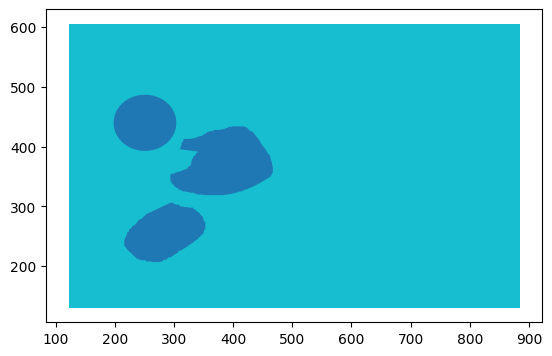

In [336]:
g_df_2.plot(column="names")

In [179]:
# g_df_2.plot()#("names")
# plt.show()

In [337]:
unique_names_set=(set(g_df_2["names"])) # get unique annotation calssification names

print(unique_names_set)

{'ICI', 'Tissue'}


### 4. User must specify the name of Islet and tissue annotations in the data 
Note, either category can be specified by multiple names (as with islet_annotation_name below 

In [338]:
islet_annotation_name=['ICI','IDI'] 
tissue_annotation_name=['Tissue']

### 5. Run annotation processing 

In [339]:

#Caluclate the limits of the frame + however much the objects will be expanded by. 
#Ratser plot the objects to this
limits_df=g_df_2.geometry.total_bounds
x_lim=int(limits_df[2].max()+expansion)
y_lim=int(limits_df[3].max()+expansion)

total_anotation_count=g_df_2.shape[0]
annotation_position=1#initialise counter through annotations
islet_index=1
tissue_index=1

islet_array=np.zeros((x_lim,y_lim), dtype=int)
# tissue_array=np.zeros((x_lim,y_lim), dtype=int)

coord_df=g_df_2.get_coordinates()#get coordinates of the polygons for use later


#Loop through islet annotations and plot islets and tissue annotations to 2 separate arrays array. Number labels by position in annotations file
for index, row in g_df_2.iterrows():
    name=row["names"]

    #Processing Islet Annotations
    if any(name in x for x in islet_annotation_name):
        #plot the annotations to np arrays
        coordinates=list(zip(coord_df.loc[index]["x"], coord_df.loc[index]["y"]))#get boundary coordinates from the polygon
        polygon=np.array(coordinates)
        mask=ski.draw.polygon2mask((x_lim, y_lim), polygon)
        islet_array[mask]=annotation_position # assign px in the mask the value of the annotation position in the geojson file to make a label image        
        
        islet_index+=1
        print(name, " added to islet label image")
        
    #Processing Tissue Annotations
#     if any(name in x for x in tissue_annotation_name):
#         #plot the annotations to np arrays
#         polygon=np.array(obj["geometry"]["coordinates"])
#         mask=ski.draw.polygon2mask((x_lim, y_lim), polygon)
#         tissue_array[mask]=annotation_position # assign px in the mask the value of the annotation position in the geojson file to make a label image        
        
#         tissue_index+=1
#         print(name, " added to tissue label image")
        
    print("Annotation ",annotation_position," of", total_anotation_count, " processed")
    annotation_position+=1 #add 1 to the annotation position number
   

Annotation  1  of 4  processed
ICI  added to islet label image
Annotation  2  of 4  processed
ICI  added to islet label image
Annotation  3  of 4  processed
ICI  added to islet label image
Annotation  4  of 4  processed


### View segmented islets

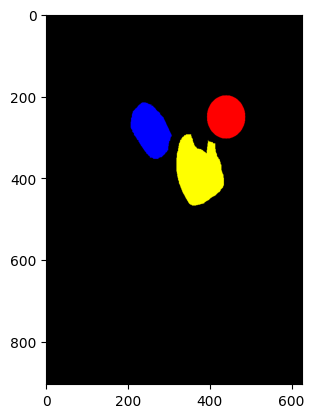

In [340]:
islet_label_img=label2rgb(islet_array, image=None, bg_label=0)
plt.imshow(islet_label_img)
plt.show()


### 6. Expand islet annotation

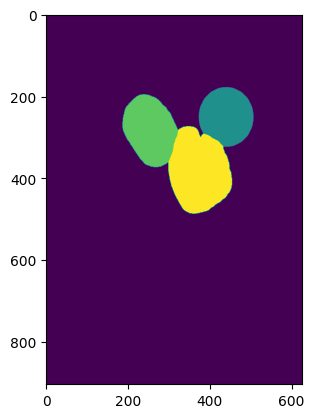

In [356]:
islet_array_expanded=ski.segmentation.expand_labels(islet_array, distance = expansion)
plt.imshow(islet_array_expanded)
plt.show()


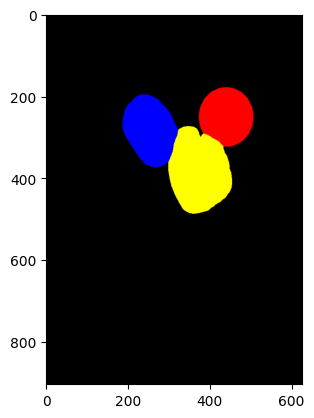

In [355]:
# # View expansion

# islet_label_img_expanded=label2rgb(islet_array_expanded, image=None, bg_label=0)
plt.imshow(islet_label_img_expanded)
plt.show()

### 7. Add outlines to new annotation file

In [398]:
#Define function to get the coordinates defining the boundaries of a polygon describing the label shape
#This is what is needed to save to a geojson file and to render an annotation in Halo (for example)

def get_label_poly(label_img, label_value):

    #1. Create a cropped version of the islet to analyse more efficiently
    islet_original_coords=np.column_stack(np.where(label_img==label_value))

    #Set the boundaries of the crop
    x = [i[0] for i in islet_original_coords]
    y = [i[1] for i in islet_original_coords]
    min_x_islet=min(x)
    max_x_islet=max(x)
    min_y_islet=min(y)
    max_y_islet=max(y)

    #Crop
    islet_crop=label_img[min_x_islet:max_x_islet, min_y_islet:max_y_islet].copy()
    islet_crop[islet_crop!=label_value]=0 #remove any other islet labels which might overlap into this cropped window
    #     plt.imshow(islet_crop)
    #     plt.show()

    #2. Get Edge of shape
    poly=imantics.Polygons.from_mask(islet_crop).points[0]
    poly_shape=shapely.polygons(poly.tolist())
    poly_shape_rotated=shapely.affinity.rotate(poly_shape, 0, origin='center', use_radians=False)##Currently this does nothing, but can rotate if needed
    linestring=shapely.boundary(poly_shape_rotated)

    adjusted_poly=shapely.transform(linestring, lambda x:x+[min_y_islet,min_x_islet])#reposition to original coordinates in the label image created
    adjusted_poly_rotated=shapely.ops.transform(lambda x,y:(y,x),adjusted_poly)#swap x and y to match the original image to which the annotations relate
        
    return adjusted_poly_rotated


ValueError: aspect must be finite and positive 

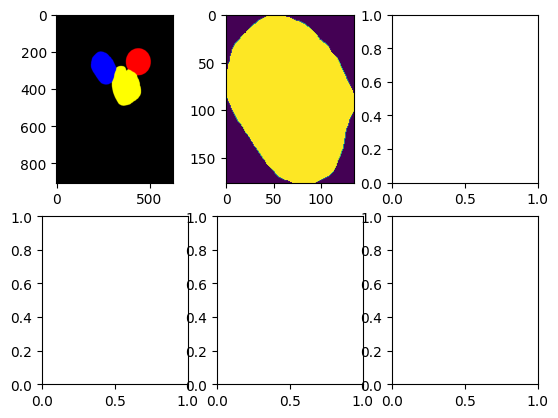

In [363]:
# Testing the function to optimise

label_img=islet_array_expanded.copy()
label_value=3
    
#1. Create a cropped version of the islet to analyse more efficiently
islet_original_coords=np.column_stack(np.where(label_img==label_value))

#Set the boundaries of the crop
x = [i[0] for i in islet_original_coords]
y = [i[1] for i in islet_original_coords]
min_x_islet=min(x)
max_x_islet=max(x)
min_y_islet=min(y)
max_y_islet=max(y)

#Crop
islet_crop=label_img[min_x_islet:max_x_islet, min_y_islet:max_y_islet].copy()
islet_crop[islet_crop!=label_value]=0 #remove any other islet labels which might overlap into this cropped window
#     plt.imshow(islet_crop)
#     plt.show()

#2. Get Edge of shape
poly=imantics.Polygons.from_mask(islet_crop).points[0]
poly_shape=shapely.polygons(poly.tolist())
poly_shape_rotated=shapely.affinity.rotate(poly_shape, 0, origin='center', use_radians=False)##output shapes are 180 degrees rotated compared to original? This should resolve.....
linestring=shapely.boundary(poly_shape_rotated)


# #Adjust coordinates to whole uncropped image
# adjusted_poly=[]
# for i in poly:
#     coord=[(i[0]+min_x_islet), (i[1]+min_y_islet)]
#     adjusted_poly.append(coord)

adjusted_poly=shapely.transform(linestring, lambda x:x+[min_y_islet,min_x_islet])#,min_y_islet



# Set up dfs for plots
g_df_test_final=g_df_2.copy()
g_df_test_final.at[label_value,"geometry"]=adjusted_poly

g_df_test_crop=g_df_2.iloc[[2]].copy()
g_df_test_crop.at[label_value,"geometry"]=linestring

g_df_test_2=g_df_2.copy()
g_df_test_2.at[label_value,"geometry"]=adjusted_poly

# fig=plt.subplot()

# g_df_test_2.plot(ax=fig, column="names", alpha=0.5)
# fig.imshow(islet_label_img_expanded)
# plt.show()

#set up plots
fig, axs = plt.subplots(2,3)

# Plot the images
axs[0,0].imshow(islet_label_img_expanded)

axs[0,1].imshow(islet_crop)

g_df_test_crop.plot(ax=axs[0,2], column="names")

axs[1,0].imshow(islet_crop)
g_df_test_crop.plot(ax=axs[1,0], column="names", alpha=0.5)
# axs[1,0].set_title("Cropped raster and geom overlay")

g_df_test_final.plot(ax=axs[1,1], column="names")



axs[1,2].imshow(islet_label_img_expanded)
g_df_test_final.plot(ax=axs[1,2], column="names", alpha=0.5)
# axs.set_title("Expansion raster and geom overlay")

# Adjust layout
# plt.tight_layout()
plt.show()


print(min_x_islet, min_y_islet)

LINESTRING (235 196, 234 197, 229 197, 228 198, 227 198, 226 199, 225 199, 224 200, 223 200, 222 201, 221 201, 217 205, 216 205, 208 213, 208 214, 207 215, 206 215, 202 219, 202 220, 196 226, 196 227, 195 228, 195 229, 194 230, 194 231, 193 232, 193 235, 192 236, 192 238, 191 239, 191 244, 190 245, 190 246, 189 247, 189 252, 188 253, 188 262, 187 263, 187 277, 188 278, 188 283, 189 284, 189 286, 190 287, 190 288, 191 289, 191 290, 192 291, 192 293, 193 294, 193 295, 194 296, 194 297, 195 298, 195 299, 196 300, 196 301, 197 302, 197 303, 198 304, 198 305, 199 306, 199 307, 203 311, 203 312, 205 314, 205 315, 206 316, 206 317, 207 318, 207 319, 210 322, 210 323, 212 325, 212 326, 213 327, 213 328, 215 330, 215 331, 216 332, 216 333, 219 336, 219 337, 221 339, 221 340, 223 342, 223 343, 225 345, 225 346, 228 349, 228 350, 229 351, 229 352, 238 361, 238 362, 242 366, 243 366, 244 367, 245 367, 246 368, 247 368, 248 369, 251 369, 252 370, 253 370, 254 371, 255 371, 256 372, 280 372, 281 371

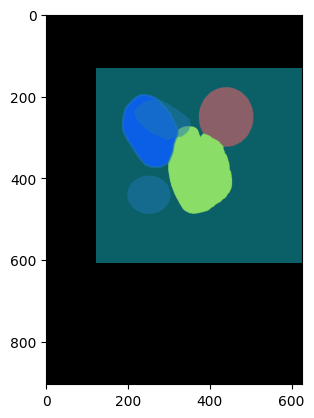

In [358]:
print(adjusted_poly)

# Set up the plots
g_df_test_2=g_df_2.copy()
g_df_test_2.at[label_value,"geometry"]=adjusted_poly

fig=plt.subplot()

g_df_test_2.plot(ax=fig, column="names", alpha=0.5)
fig.imshow(islet_label_img_expanded)
plt.show()

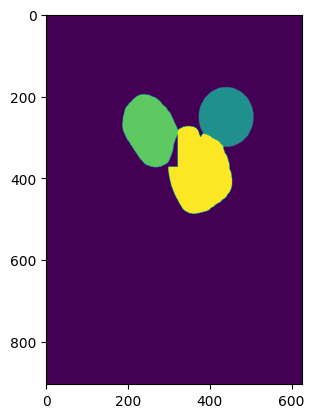

In [359]:
plt.imshow(label_img)
plt.show()

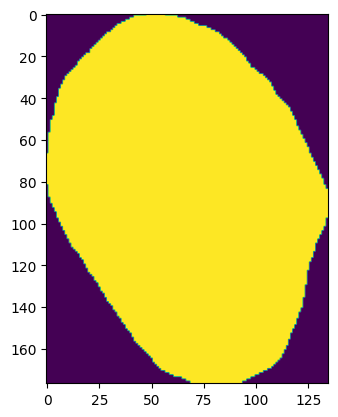

In [365]:
plt.imshow(islet_crop)
plt.show()

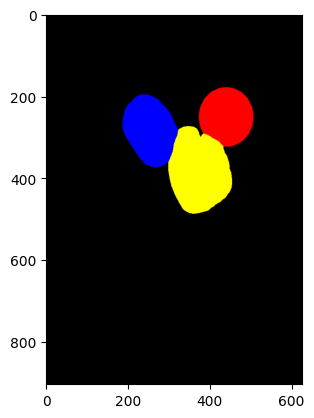

In [207]:
# plt.imshow(islet_array_expanded)
plt.imshow(islet_label_img_expanded)
plt.show()


In [188]:
# x=[i[0] for i in coords]
# y=[i[1] for i in coords]

# minx=min(x)
# maxx=max(x)
# miny=min(y)
# maxy=max(y)

# new_coords=[]
# for i in coords:
#     x=i[0]-minx
#     y=i[1]-miny
#     new=(x,y)
#     new_coords.append(new)
# # ski.draw.polygon2mask((x_lim, y_lim), polygon)

# polygon=np.array(new_coords)
# frame_x=maxx-minx
# frame_y=maxy-miny
# mask=ski.draw.polygon2mask((frame_x, frame_y), polygon)
# plt.imshow(mask)


In [189]:
# #Modifying the function to imrpve how shapes are being outputted
# label_img=islet_array_expanded
# label_value=20

# #1. Create a cropped version of the islet to analyse more efficiently
# islet_original_coords=np.column_stack(np.where(label_img==label_value))

# #Set the boundaries of the crop
# x = [i[0] for i in islet_original_coords]
# y = [i[1] for i in islet_original_coords]
# min_x_islet=min(x)
# max_x_islet=max(x)
# min_y_islet=min(y)
# max_y_islet=max(y)

# #Crop
# islet_crop=label_img[min_x_islet:max_x_islet, min_y_islet:max_y_islet]
# islet_crop[islet_crop!=label_value]=0 #remove any other islet labels which might overlap into this cropped window
# plt.imshow(islet_crop)
# plt.show()



# # edge_coords=np.column_stack(np.where(edge>0))
# # poly=approximate_polygon(edge_coords, tolerance=1)##Make into polygon coordinates

# # #Adjust coordinates to whole uncropped image
# # adjusted_poly=[]
# # for i in poly:
# #     coord=[(i[0]+min_x_islet), (i[1]+min_y_islet)]
# #     adjusted_poly.append(coord)
    
# # return adjusted_poly

In [190]:
# from skimage.measure import find_contours, approximate_polygon, subdivide_polygon

# contour=find_contours(islet_crop,0)
# # coords=approximate_polygon(islet_crop, tolerance=1)

# temp_array=np.zeros((frame_x, frame_y), dtype=int)

# len(contour)


In [191]:
# exp_poly_coords=get_label_poly(islet_array_expanded, 19)
    
# #C. Add new shape to the geo df 
# geom_expanded=shapely.LineString(exp_poly_coords)

# geom_expanded

In [368]:
exp_shape=get_label_poly(islet_array_expanded, 2)

TypeError: 'builtin_function_or_method' object does not support item assignment

<Axes: >

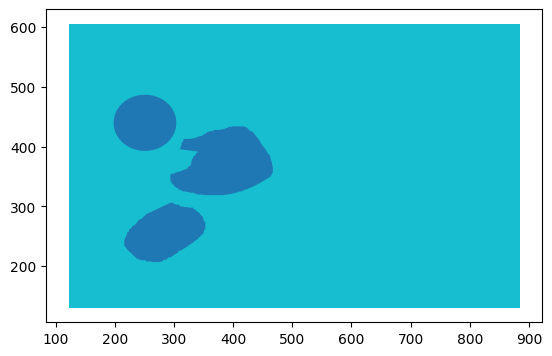

In [195]:
g_df.plot("names")

## Make new geo df

In [400]:
#1. Copy the input geojson
df_expanded=g_df_2.copy()
df_copy=g_df_2.copy()
# islet_df=g_df_2[g_df_2["names"].isin(islet_annotation_name)]#copy only original islet data, then override with the new coordinates
# g_df_2_expanded = islet_df=g_df_2[g_df_2["names"].isin(islet_annotation_name)]#copy only original islet data, then override with the new coordinates

#2. Loop through the islet annotations
label_values=np.unique(islet_array_expanded) # get unique label values
label_values=label_values[label_values>0] # remove zeros

for islet_label in label_values:
    
    annotation_no=islet_label-1 # index from 0 
    
    print("working on islet", islet_label)
    
    #A. Rename original annotation with a numbered index for referencing
    df_expanded.at[annotation_no,"names"]="Expanded_Islet_"+str(islet_label)
    df_copy.at[annotation_no,"names"]="Islet_"+str(islet_label)
      
    print("step 2A done")
    
    #B. Get coordinates of the expanded corresponding annotation
    exp_shape=get_label_poly(islet_array_expanded, islet_label)
    
    print("2B done")
    
    #C. Add new shape to the geo df 
    df_expanded.at[annotation_no,"geometry"]=exp_shape
    
    print("Islet ",islet_label," of ", len(label_values), " processed" )

working on islet 2
step 2A done
2B done
Islet  2  of  3  processed
working on islet 3
step 2A done
2B done
Islet  3  of  3  processed
working on islet 4
step 2A done
2B done
Islet  4  of  3  processed


## View output

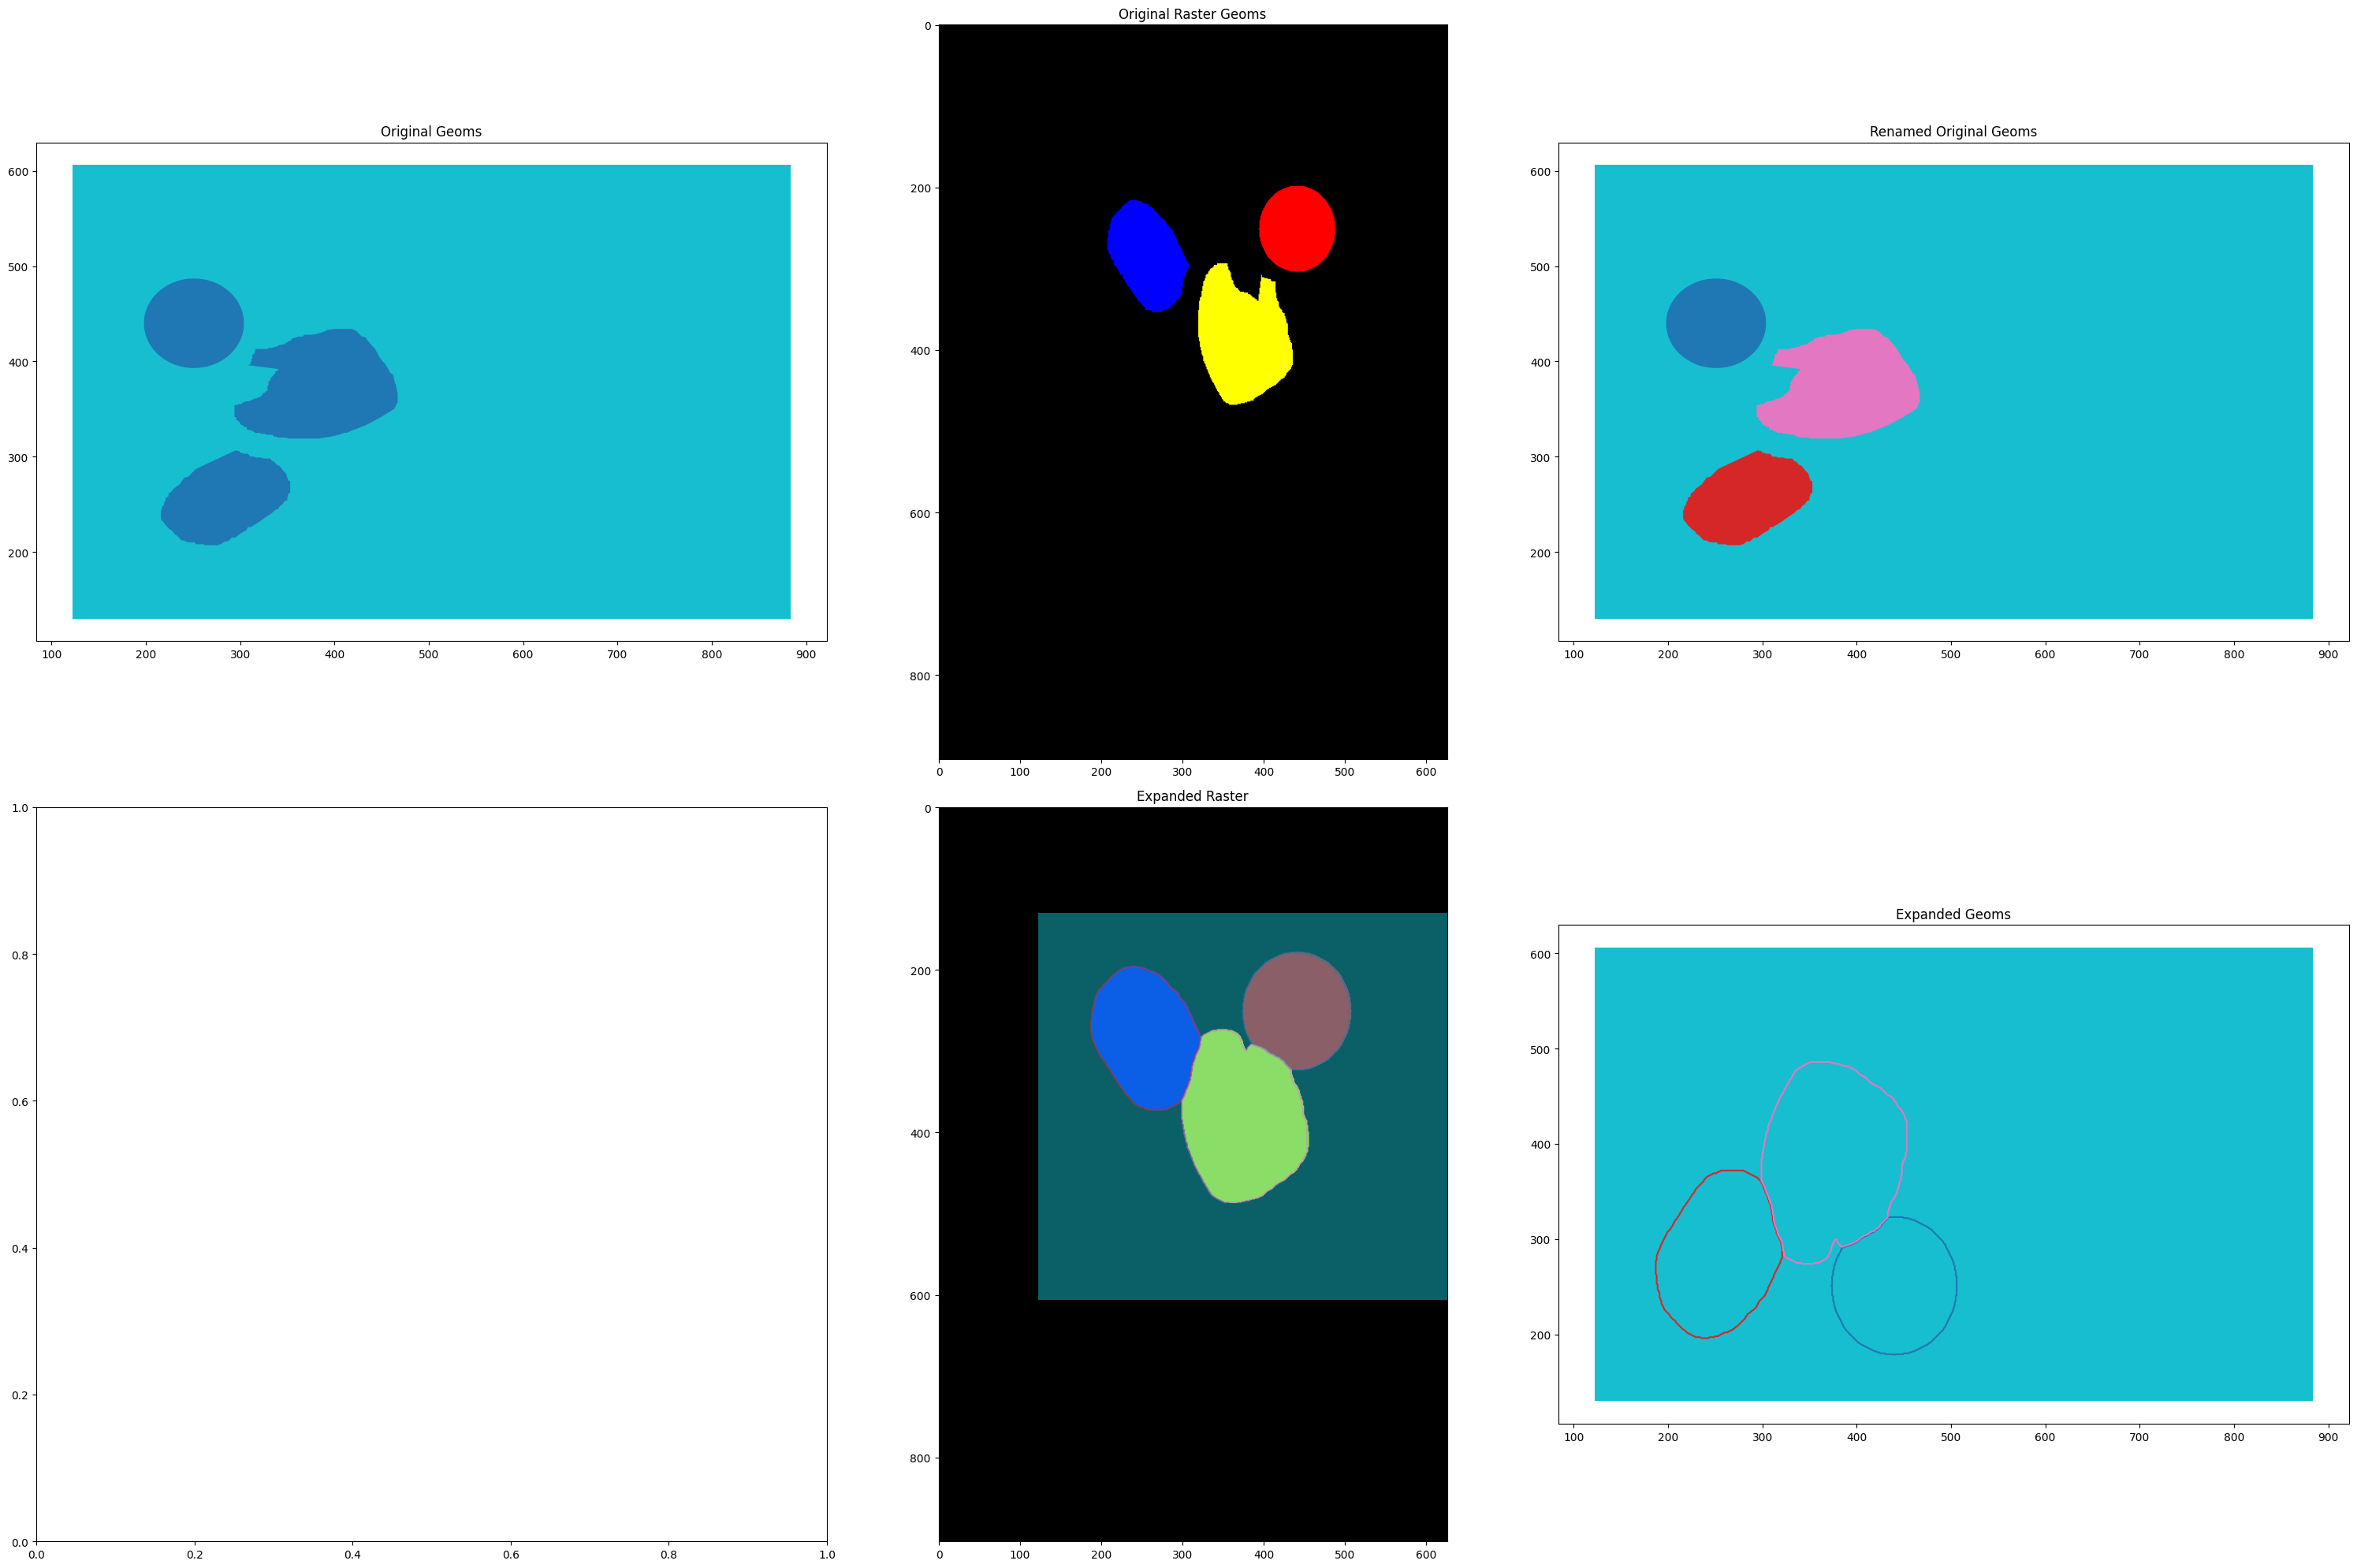

In [385]:
# Set up the subplots
fig, axs = plt.subplots(2, 3, figsize=(30, 20))

# Plot the images
g_df_2.plot(ax=axs[0, 0], column="names")
axs[0, 0].set_title("Original Geoms")

axs[0, 1].imshow(islet_label_img)
axs[0, 1].set_title("Original Raster Geoms")

df_copy.plot(ax=axs[0, 2], column="names")
axs[0, 2].set_title("Renamed Original Geoms")

axs[1, 1].imshow(islet_label_img_expanded)
df_expanded.plot(ax=axs[1, 1], column="names", alpha=0.5)
axs[1, 1].set_title("Expansion raster and geom overlay")


axs[1, 1].imshow(islet_label_img_expanded)
axs[1, 1].set_title("Expanded Raster")

df_expanded.plot(ax=axs[1, 2], column="names")
axs[1, 2].set_title("Expanded Geoms")

# Adjust layout
plt.tight_layout()
plt.show()


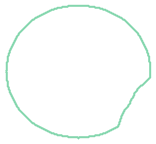

In [397]:
shapely.ops.transform(lambda x,y:(y,x),adjusted_poly)

In [401]:
#Save new geojson
from geojson import dump #Point, Feature, FeatureCollection, 

# Set the location of the geojson annotation file to be used (NB. new files will be saved to the same location with modified names)
annotation_file_write_path = 'C:/Users/jcc234/OneDrive - University of Exeter/Documents/Projects/Bec/Islet expansion python/QuPath proj/Reduced_annotations_for_testing_expanded_'+str(expansion)+'.geojson' 



with open(annotation_file_write_path, 'w') as f:
   dump(df_expanded, f)

In [125]:
import datetime

message="Finished at "+str((datetime.datetime.now()))

2024-07-18 15:22:03.602935


## Making test geoj with original annotations taken from the label image to check chenges in orientation



In [399]:
#1. Copy the input geojson
df_extracted=g_df_2.copy()

#2. Loop through the islet annotations
label_values=np.unique(islet_array) # get unique label values
label_values=label_values[label_values>0] # remove zeros

for islet_label in label_values:
    
    annotation_no=islet_label-1 # index from 0 
    
    print("working on islet", islet_label)
    
    #A. Rename original annotation with a numbered index for referencing
    df_extracted.at[annotation_no,"names"]="Expanded_Islet_"+str(islet_label)
    df_copy.at[annotation_no,"names"]="Islet_"+str(islet_label)
      
    print("step 2A done")
    
    #B. Get coordinates of the expanded corresponding annotation
    exp_shape=get_label_poly(islet_array, islet_label)
    
    print("2B done")
    
    #C. Add new shape to the geo df 
    df_extracted.at[annotation_no,"geometry"]=exp_shape
    
    print("Islet ",islet_label," of ", len(label_values), " processed" )


#Save new geojson
from geojson import dump #Point, Feature, FeatureCollection, 

# Set the location of the geojson annotation file to be used (NB. new files will be saved to the same location with modified names)
annotation_file_write_path = 'C:/Users/jcc234/OneDrive - University of Exeter/Documents/Projects/Bec/Islet expansion python/QuPath proj/Reduced_annotations_for_testing_expanded_original_re-extracted.geojson' 

with open(annotation_file_write_path, 'w') as f:
   dump(df_extracted, f)

working on islet 2
step 2A done
2B done
Islet  2  of  3  processed
working on islet 3
step 2A done
2B done
Islet  3  of  3  processed
working on islet 4
step 2A done
2B done
Islet  4  of  3  processed


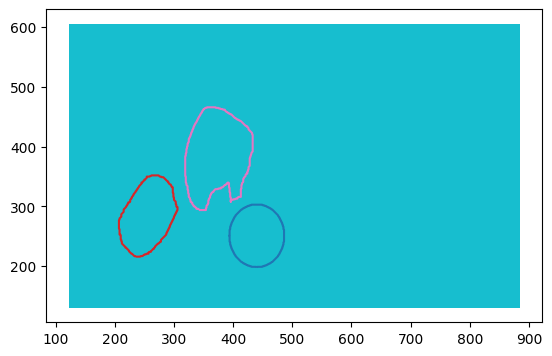

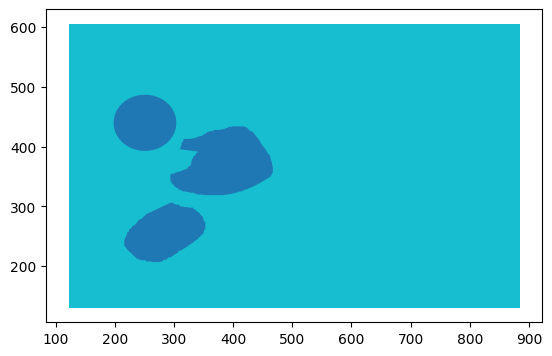

In [393]:
df_extracted.plot(column="names")
plt.show()

g_df_2.plot(column="names")
plt.show()

ValueError: aspect must be finite and positive 

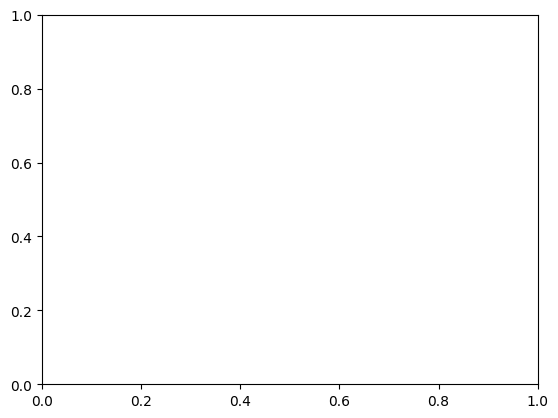

In [45]:
expanded_islets_only_df=df_expanded[df_expanded["names"].str.match("Islet.*")]
expanded_islets_only_df.plot()
plt.show()


### 8. Export coordinates of expanded mask for new annotations 

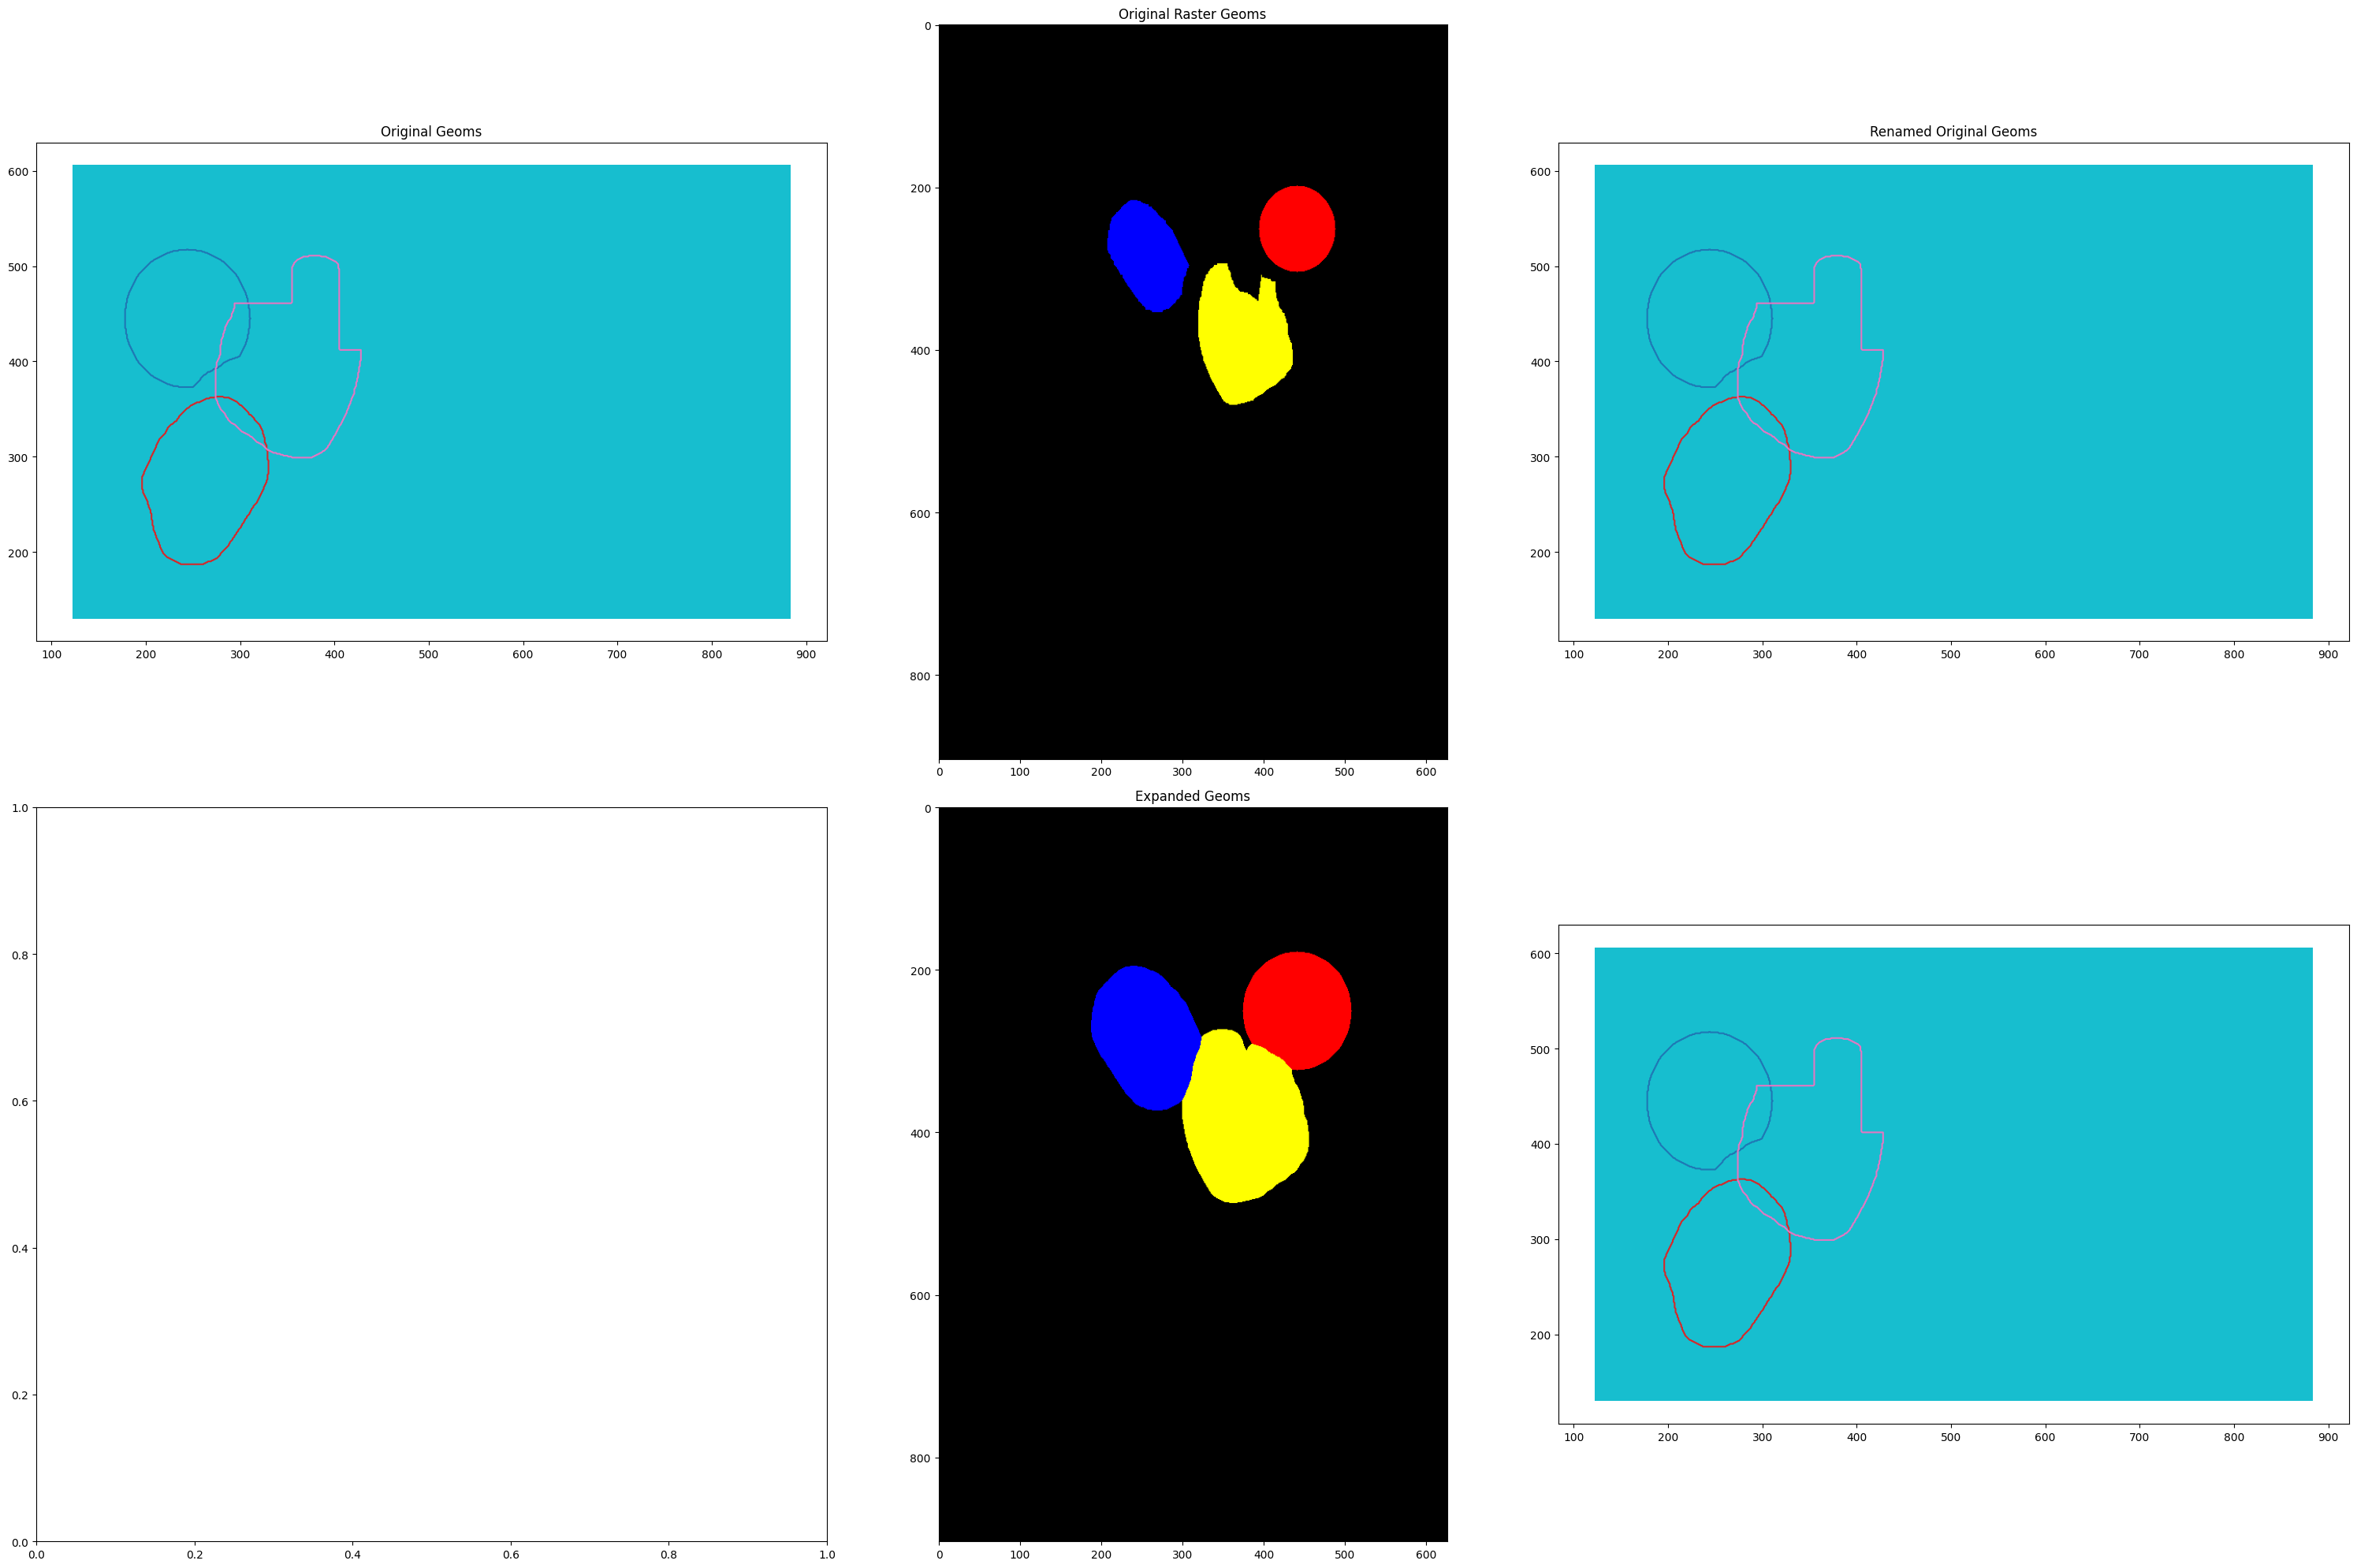

<Axes: >

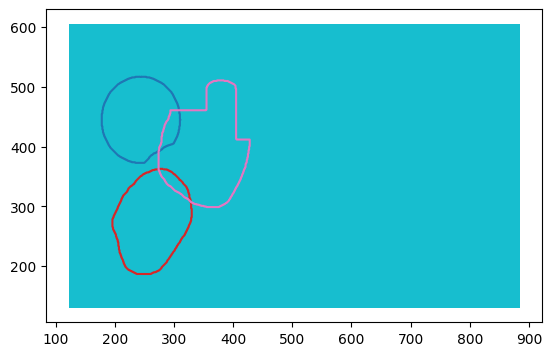

In [97]:
df_expanded.plot("names")

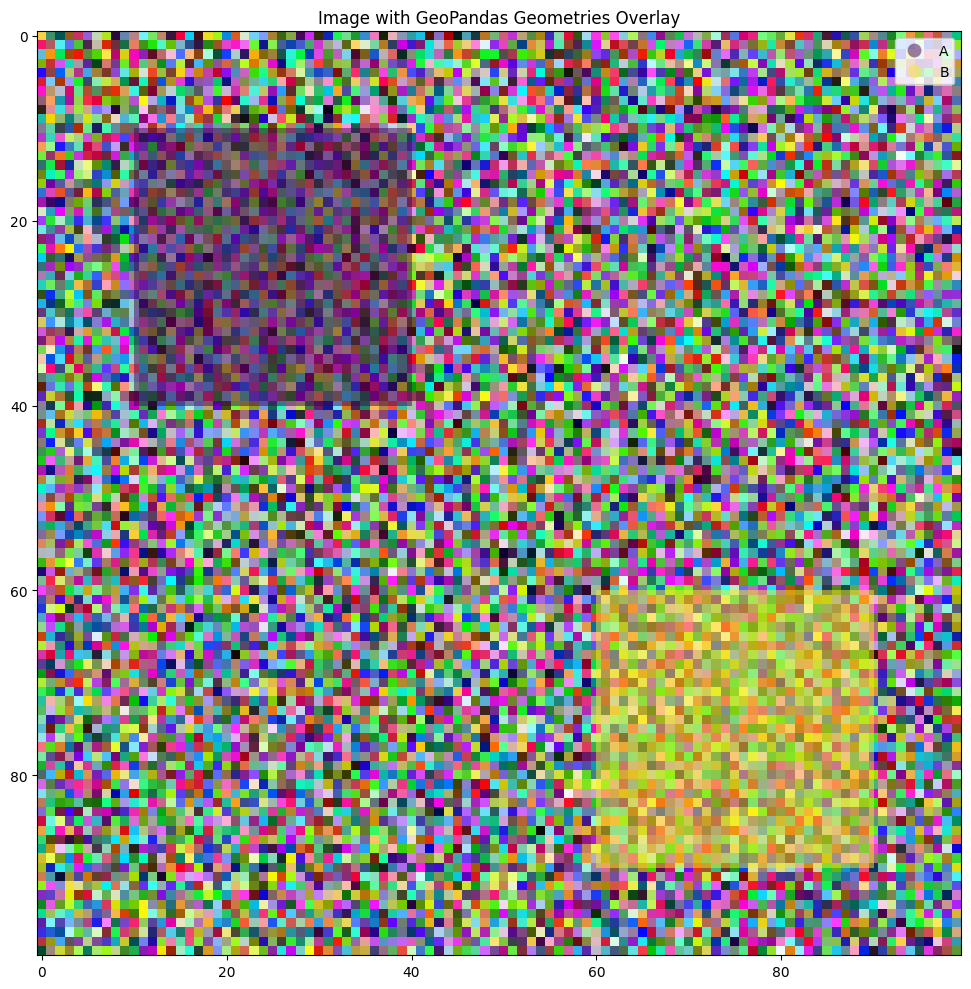

In [145]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon

# Step 1: Create sample data
# Create a sample NumPy array representing an image
image = np.random.rand(100, 100, 3)  # Random RGB image

# Create a sample GeoPandas DataFrame with geometries
polygons = [
    Polygon([(10, 10), (40, 10), (40, 40), (10, 40)]), 
    Polygon([(60, 60), (90, 60), (90, 90), (60, 90)])
]
names = ['A', 'B']
gdf = gpd.GeoDataFrame({'geometry': polygons, 'name': names})

# Step 2: Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Step 3: Plot the image
ax.imshow(image)
ax.set_title("Image with GeoPandas Geometries Overlay")

# Step 4: Overlay the geometries
gdf.plot(ax=ax, column='name', legend=True, cmap='viridis', alpha=0.5)

# Adjust layout
plt.tight_layout()
plt.show()
